In [32]:
#Import the packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
%matplotlib inline

In [33]:
#Import the dataset
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
full = train.append(test, ignore_index=True)

In [34]:
print(train.shape,test.shape,full.shape)

(2051, 82) (879, 80) (2930, 82)


Preprocessing

In [35]:
full[full.columns[full.isnull().any()]].isnull().sum().sort_values(ascending=False)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Sale Condition     879
SalePrice          879
Lot Frontage       490
Garage Qual        159
Garage Cond        159
Garage Finish      159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Electrical           1
Garage Cars          1
Garage Area          1
dtype: int64

In [36]:

#drop the features with 40 percent of missing values
features = pd.concat([train, test], keys=['train', 'test'])
features.drop(['Pool QC', 'Misc Feature', 'Fireplace Qu', 'Fence', 'Alley','PID'],
              axis=1, inplace=True)
features.shape

(2930, 76)

In [37]:
#features with missing values
features.isnull().sum().sort_values(ascending=False).head(25)

SalePrice         879
Sale Condition    879
Lot Frontage      490
Garage Qual       159
Garage Finish     159
Garage Cond       159
Garage Yr Blt     159
Garage Type       157
Bsmt Exposure      83
BsmtFin Type 2     81
Bsmt Qual          80
BsmtFin Type 1     80
Bsmt Cond          80
Mas Vnr Area       23
Mas Vnr Type       23
Bsmt Full Bath      2
Bsmt Half Bath      2
Total Bsmt SF       1
Electrical          1
Garage Area         1
Garage Cars         1
BsmtFin SF 2        1
BsmtFin SF 1        1
Bsmt Unf SF         1
Functional          0
dtype: int64

In [38]:
#fill the nas
features['Sale Condition'] = features['Sale Condition'].fillna(features['Sale Condition'].mode()[0])
features['Lot Frontage'] = features['Lot Frontage'].fillna(features['Lot Frontage'].mean())
for col in ('Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond'):
    features[col] = features[col].fillna('NoGRG')
features['Garage Cars'] = features['Garage Cars'].fillna(0.0)
features['Garage Area'] = features['Garage Area'].fillna(0.0)
features.drop(['Total Bsmt SF',  'Garage Yr Blt'], axis=1, inplace=True)
features['BsmtFin SF 1'] = features['BsmtFin SF 1'].fillna(0)   
features['BsmtFin SF 2'] = features['BsmtFin SF 2'].fillna(0)  
features['Bsmt Full Bath'] = features['Bsmt Full Bath'].fillna(features['Bsmt Full Bath'].median())
features['Bsmt Half Bath'] = features['Bsmt Half Bath'].fillna(features['Bsmt Half Bath'].median())
features['Bsmt Unf SF'] = features['Bsmt Unf SF'].fillna(features['Bsmt Unf SF'].mean())
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
for col in ('Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Cond','Bsmt Qual'):
    features[col] = features[col].fillna('NoBasement')
features['Mas Vnr Area'] = features['Mas Vnr Area'].fillna(0.0)
features['Mas Vnr Type'] = features['Mas Vnr Type'].fillna('None')

In [39]:
#check nas
features.isnull().sum().sort_values(ascending=False).head(5)

SalePrice         879
Yr Sold             0
Full Bath           0
Enclosed Porch      0
Exter Cond          0
dtype: int64

In [47]:
#fill nas with mean in saleprice 
features['SalePrice'] = features['SalePrice'].fillna(features['SalePrice'].mean()) 

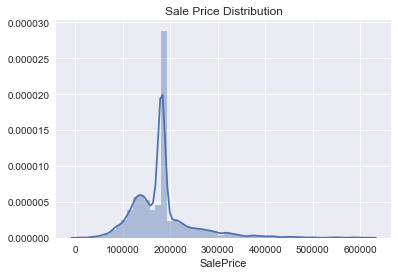

In [48]:
sns.distplot(features['SalePrice'])
sns.plt.title('Sale Price Distribution')

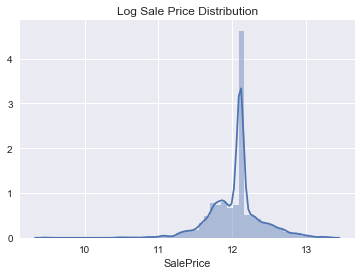

In [92]:
sns.distplot(np.log(features['SalePrice']))
sns.plt.title('Log Sale Price Distribution')

In [46]:
print('Sale Price Mean',y_observed.mean())
print('Sale Price Std Dev',y_observed.std())

Sale Price Mean 181469.70160897123
Sale Price Std Dev 79258.65935236562


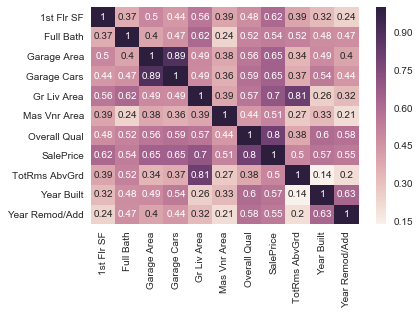

In [72]:
corr=features.corr()
high_corr= corr.index[abs(corr["SalePrice"])>0.4]
sns.heatmap(train[high_corr].corr(),annot=True)

In [74]:
features.describe()

,1st Flr SF,2nd Flr SF,3Ssn Porch,Bedroom AbvGr,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Enclosed Porch,...,Overall Cond,Overall Qual,Pool Area,SalePrice,Screen Porch,TotRms AbvGrd,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1159.557679,335.455973,2.592491,2.854266,0.431058,0.061092,559.262547,442.478498,49.705461,23.011604,...,5.563140,6.094881,2.243345,181469.701609,16.002048,6.443003,93.751877,1971.356314,1984.266553,2007.790444
std,391.890885,428.395715,25.141331,0.827731,0.524762,0.245175,439.419122,455.586452,169.142089,64.139059,...,1.111537,1.411026,35.597181,66307.700431,56.087370,1.572964,126.361562,30.245361,20.860286,1.316613
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,12789.000000,0.000000,2.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.250000,0.000000,0.000000,2.000000,0.000000,0.000000,219.000000,0.000000,0.000000,0.000000,...,5.000000,5.000000,0.000000,142500.000000,0.000000,5.000000,0.000000,1954.000000,1965.000000,2007.000000
50%,1084.000000,0.000000,0.000000,3.000000,0.000000,0.000000,466.000000,370.000000,0.000000,0.000000,...,5.000000,6.000000,0.000000,181469.701609,0.000000,6.000000,0.000000,1973.000000,1993.000000,2008.000000
75%,1384.000000,703.750000,0.000000,3.000000,1.000000,0.000000,801.750000,734.000000,0.000000,0.000000,...,6.000000,7.000000,0.000000,186600.000000,0.000000,7.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,3.000000,2.000000,2336.000000,5644.000000,1526.000000,1012.000000,...,9.000000,10.000000,800.000000,611657.000000,576.000000,15.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [75]:
sale_condition=[]
for i in train['Sale Condition']:
    if i=='Normal':
        sale_condition.append(0)
    else:
        sale_condition.append(1)

In [76]:
train['Sale Condition']=sale_condition

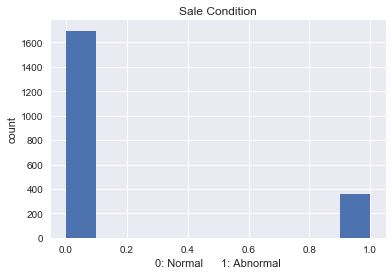

In [88]:
plt.hist(train['Sale Condition'])
plt.title('Sale Condition')
plt.xlabel('0: Normal'+'      '+'1: Abnormal')
plt.ylabel('count')